In [2806]:
import hydra
import torch

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

In [2807]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_11192/1048885480.py:2: DtypeWarning: Columns (10,16,20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257031,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
257032,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
257033,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
257034,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,1,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [2808]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma
    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, torch.nan]) # allows curve

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & bound_func]

    return df_subsetted

In [2809]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma=-1",
    "simulation/dynamics=nowak_krakauer"
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

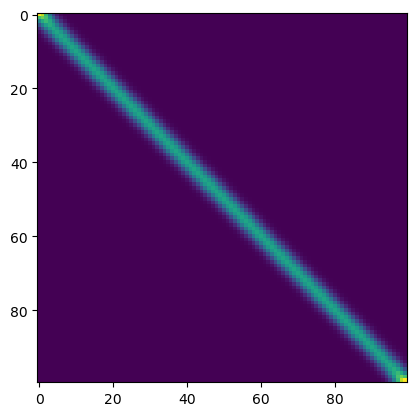

In [2810]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

In [2811]:
# visualize the curve!
df = get_df_subsetted_by_meaning_dists(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
98429,2.984610,2.716010,0.764763,28.521690,0.000352,-0.000718,1.031968,0.0,simulation,NaN,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN
98430,5.896252,2.803171,0.677602,1831.775400,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN
98431,2.874299,2.561625,0.919148,50.193974,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN
98432,2.810374,2.557166,0.923607,35.483210,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN
98433,2.740817,2.519548,0.961225,36.637020,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234873,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
234874,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
234875,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo
234876,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo


In [2812]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

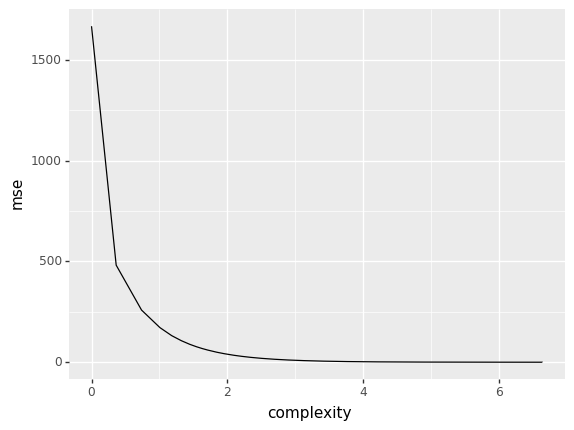

<ggplot: (1072340743)>

In [2813]:
(
    pn.ggplot(df_mse_bound, pn.aes(x="complexity", y="mse"))
    + pn.geom_line()
)

In [2814]:
langs = df_final_points[df_final_points["population_init_gamma"] == -3]
langs

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
99439,2.986770,2.717461,0.763311,28.465368,0.002344,0.003634,1.024683,0.0,simulation,NaN,...,-8,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
100853,3.006457,2.730230,0.750543,27.981644,0.006130,0.010386,1.024683,0.0,simulation,NaN,...,-8,100,squared_dist,1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
102267,2.865991,2.635403,0.845369,31.872868,0.021427,0.028745,0.939293,0.0,simulation,NaN,...,-8,100,squared_dist,-1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
103681,1.818070,1.768271,1.712501,108.810550,0.011818,-0.013327,0.768512,0.0,simulation,NaN,...,-8,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
105095,3.006290,2.730128,0.750645,27.984982,0.006103,0.010321,1.024683,0.0,simulation,NaN,...,-8,100,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
106509,3.006290,2.730125,0.750648,27.985165,0.006103,0.010323,1.024683,0.0,simulation,NaN,...,-8,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
107923,2.455834,2.323949,1.156824,49.274193,0.002446,-0.005727,0.853903,0.0,simulation,NaN,...,-8,100,squared_dist,-2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN
113910,5.879842,2.801843,0.678930,1467.216400,0.077890,0.019631,22.116077,0.0,simulation,NaN,...,-8,100,squared_dist,0.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN
114816,5.277869,2.262438,1.218335,1731.145300,0.171494,0.051255,15.284857,0.0,simulation,NaN,...,-8,100,squared_dist,1.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN
115792,5.507798,2.453434,1.027339,1607.759300,0.128081,0.065280,13.918612,0.0,simulation,NaN,...,-8,100,squared_dist,-1.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


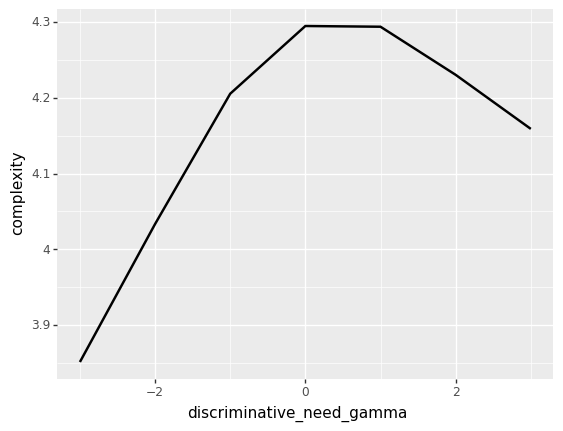

<ggplot: (1004864263)>

In [2815]:
(
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_smooth()
)

In [2816]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]

In [2817]:
# restrict dynamics
df_final_points = df_final_points[df_final_points["dynamics"] == "nowak_krakauer"]

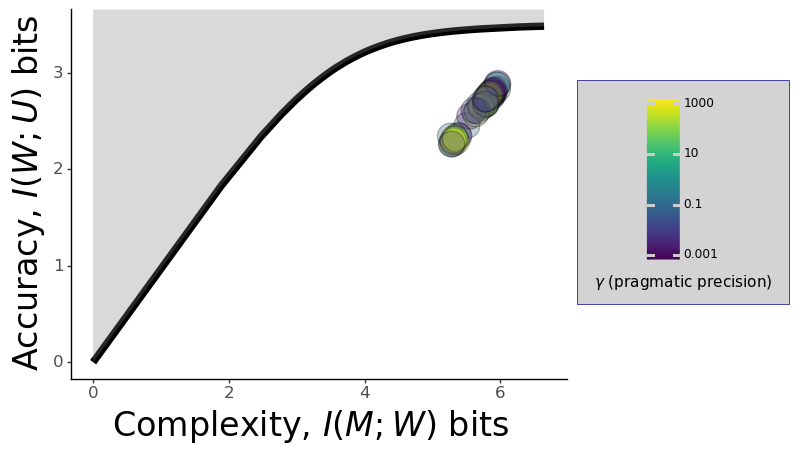

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: evolang_figure


In [2818]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
        alpha=0.3,
        size=10,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)
plot.save("evolang_figure", width=6, height=6, dpi=300,)

In [2819]:
# restrict to one specific gamma at a time
gammas = [
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
df_final_points = df_final_points[df_final_points["discriminative_need_gamma"].isin(gammas)]

In [2820]:
df_final_points = df_final_points[df_final_points["population_init_gamma"] == -3]
df_final_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
116853,5.886111,2.814897,0.665875,1652.681,0.080639,0.015715,23.396931,0.0,simulation,NaN,...,-8,100,squared_dist,0.001,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN


In [2821]:
df_final_points["discriminative_need_gamma"] = df_final_points["discriminative_need_gamma"].astype(str)

In [2822]:
# this is a dirty and beautiful hack from
# https://waldyrious.net/viridis-palette-generator/
fill_values_dict = {
    str(k): v for k, v in {
        "0.001": "#440154",
        "0.01": "#443983",
        "0.1": "#31688e",
        "1.0": "#21918c",
        "10.0": "#35b779",
        "100.0" : "#90d743",
        "1000.0": "#fde725", 
    }.items() }


In [2823]:
# Make sure complexity max is np.log2(100)
df_ib_bound.complexity.max()

6.643731996664289

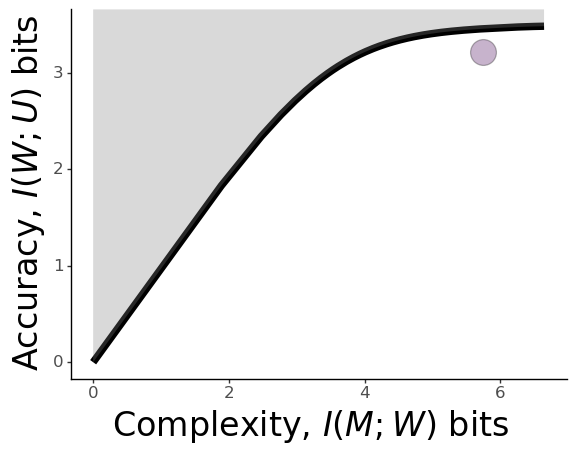

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: slide_figure


In [2824]:
# for slides

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
)

if True:
    plot = (
        plot 
        + pn.geom_jitter( # emergent langs
            data=df_final_points,
            mapping=pn.aes(
                # fill="discr_need",
                fill="discriminative_need_gamma",
                # shape="language",
                ),
            alpha=0.3,
            size=10,
            # fill="orange",
        )
        + pn.labs(fill="$\\gamma$ (pragmatic precision)")
        # + pn.scale_fill_continuous(
        #     trans = "log10",
        # )
        + pn.scale_fill_manual(values = fill_values_dict) 
    )
    
plot = (
    plot
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.4),
        legend_position='none',
    )    
)

print(plot)
plot.save("slide_figure", width=10, height=10, dpi=300,)

# df_final_points["discriminative_need_gamma"] = df_final_points["discriminative_need_gamma"].astype(float)

In [2825]:
df_traj_points = df[df["point_type"] == "trajectory"]

df_traj_points["iteration"] = df_traj_points["round"]

# restrict dynamics
df_traj_points = df_traj_points[df_traj_points["dynamics"] == "nowak_krakauer"]

# restrict the initialization and gamma
new_df = df_traj_points.loc[(df_traj_points['population_init_gamma'] == -3) & (df_traj_points["discriminative_need_gamma"] == 3)]


# optionally filter points
# new_df = new_df[new_df["iteration"] == new_df["iteration"].max()]


In [2826]:
df_fudge = pd.DataFrame(
    {
        "complexity": 0.,
        "accuracy": 0.,
        "point_type": "trajectory",
        "round": 0.,
        "discriminative_need_gamma": -3.0,
        "population_init_gamma": 3.0,
        "iteration": 0.,
    },
    index=[0]
)
df_fudge
# new_df = pd.concat([df_fudge, new_df])

new_df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,iteration
117848,0.183606,0.023806,3.456967,1661.0945,NaN,NaN,NaN,1.0,trajectory,0.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,0.0
117849,0.400354,0.053164,3.427608,1663.1511,NaN,NaN,NaN,1.0,trajectory,1.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,1.0
117850,0.671861,0.092555,3.388218,1669.9580,NaN,NaN,NaN,1.0,trajectory,2.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,2.0
117851,0.893776,0.125289,3.355484,1671.0303,NaN,NaN,NaN,1.0,trajectory,3.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,3.0
117852,1.086863,0.153040,3.327733,1676.4109,NaN,NaN,NaN,1.0,trajectory,4.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117997,5.302052,2.281364,1.199409,1758.9384,NaN,NaN,NaN,1.0,trajectory,149.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,149.0
117998,5.300299,2.279557,1.201216,1753.0988,NaN,NaN,NaN,1.0,trajectory,150.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,150.0
117999,5.310696,2.287958,1.192815,1741.4619,NaN,NaN,NaN,1.0,trajectory,151.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,151.0
118000,5.301503,2.280439,1.200334,1749.9581,NaN,NaN,NaN,1.0,trajectory,152.0,...,100,squared_dist,3.0,-1,nowak_krakauer,-1.0,-3.0,42.0,NaN,152.0


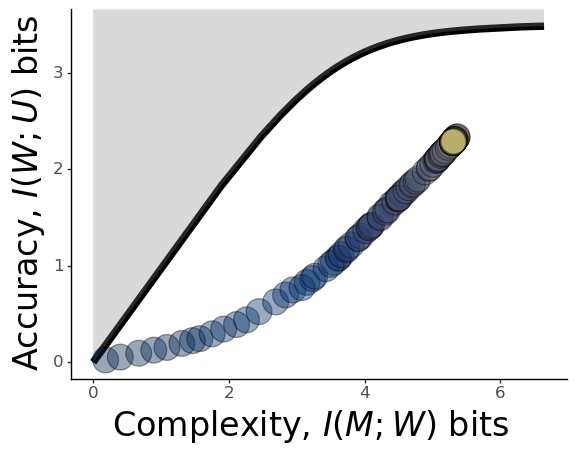

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: temp_slide_traj


In [2827]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )
    # + pn.geom_point(size=1)
    + pn.geom_line(size=3) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )
    # + pn.labs(fill="iteration")
    # + pn.scale_fill_continuous("cividis")
    + pn.scale_fill_continuous(
        "cividis",
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.325),
        legend_position='none',
        # legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, 
            linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("temp_slide_traj", width=10, height=10, dpi=300,)

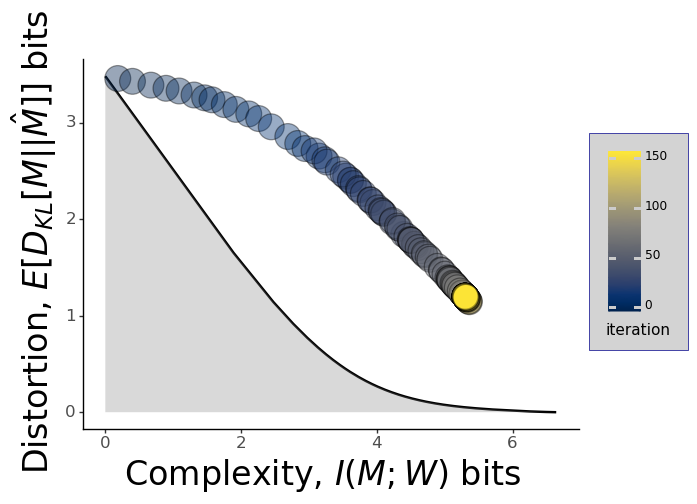

In [2828]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="distortion")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="distortion",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )
    + pn.scale_fill_continuous("cividis")
    # + pn.labs(fill="iteration")
    # + pn.scale_fill_continuous(
    #     type="magma",
    #     breaks=[0, 50, 100, 150, 200],
    #     limits=[0, 200],
    # )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Distortion, $E[D_{KL}[M || \hat{M}]]$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)

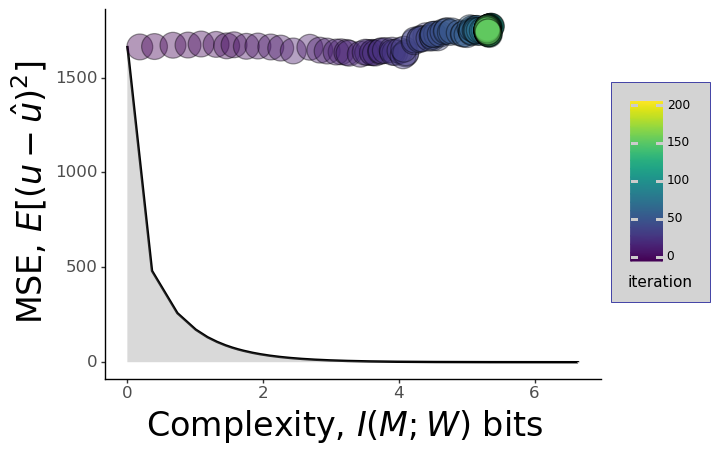

In [2829]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_mse_bound, mapping=pn.aes(x="complexity", y="mse")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="mse",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )

    + pn.labs(fill="iteration")
    + pn.scale_fill_continuous(
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("MSE, $E[(u - \hat{u})^2]$")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)